In [14]:
# imports
from sentence_transformers import SentenceTransformer, util
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
# plotting imports
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
# importing custom scripts
import sys
sys.path.append('../utils')
from functions import *

In [28]:
# just declare the embedder object once and for all
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [29]:
# read in the two metadatas as dataframe
curated_md = pd.read_csv('../data/curated_meta.csv', low_memory=False)
new_md = pd.read_csv('../data/new_meta.csv')

### ignore from curated, the columns with ontology

In [30]:
# declare the list of ontology column names
ontology_columns_curated = ['age_group_ontology_term_id', 'body_site_ontology_term_id', 'country_ontology_term_id', 
'feces_phenotype_metric_ontology_term_id', 'sex_ontology_term_id', 'hla_ontology_term_id', 'smoker_ontology_term_id', 
'control_ontology_term_id', 'target_condition_ontology_term_id', 'disease_ontology_term_id', 'treatment_ontology_term_id']

In [31]:
# remove them from the curated_md dataframe
curated_md.drop(axis = 1, labels=ontology_columns_curated, inplace=True)
curated_md.head()

,study_name,sample_id,age_years,age_min,age_max,age_group,biomarker,body_site,country,dietary_restriction,...,smoker,control,target_condition,disease,antibiotics_current_use,treatment,tumor_staging_ajcc,tumor_staging_tnm,unmetadata,westernized
0,AsnicarF_2017,MV_FEI1_t1Q14,0.246575,0.246575,0.246575,Infant,NaN,feces,Italy,NaN,...,NaN,Study Control,human gut microbiome,Healthy,NaN,NaN,NaN,NaN,NaN,Yes
1,AsnicarF_2017,MV_FEI2_t1Q14,0.246575,0.246575,0.246575,Infant,NaN,feces,Italy,NaN,...,NaN,Study Control,human gut microbiome,Healthy,NaN,NaN,NaN,NaN,NaN,Yes
2,AsnicarF_2017,MV_FEI3_t1Q14,0.246575,0.246575,0.246575,Infant,NaN,feces,Italy,NaN,...,NaN,Study Control,human gut microbiome,Healthy,NaN,NaN,NaN,NaN,NaN,Yes
3,AsnicarF_2017,MV_FEI4_t1Q14,1.000000,1.000000,1.000000,Infant,NaN,feces,Italy,NaN,...,NaN,Study Control,human gut microbiome,Healthy,NaN,NaN,NaN,NaN,NaN,Yes
4,AsnicarF_2017,MV_FEI4_t2Q15,1.000000,1.000000,1.000000,Infant,NaN,feces,Italy,NaN,...,NaN,Study Control,human gut microbiome,Healthy,NaN,NaN,NaN,NaN,NaN,Yes


### ignore from both, exactly same-name columns with new

In [32]:
# first, make all columns in new_md into lowercase as that seems to be the standard looking at curated_md.columns
new_md.rename(axis = 1, mapper = lambda x: x.lower(), inplace=True)
new_md.head()

,study_name,sample_id,subject_id,body_site,antibiotics_current_use,study_condition,disease,age,infant_age,age_category,...,hla_dqa12,hla_dqa11,hla_drb11,zigosity,brinkman_index,alcohol_numeric,breastfeeding_duration,formula_first_day,alt,egfr
0,HanniganGD_2017,MG100208,HanniganGD_2017_A29,stool,no,adenoma,adenoma,45.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HanniganGD_2017,MG100207,HanniganGD_2017_A28,stool,no,adenoma,adenoma,50.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HanniganGD_2017,MG100206,HanniganGD_2017_A27,stool,no,adenoma,adenoma,68.0,NaN,senior,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HanniganGD_2017,MG100205,HanniganGD_2017_A26,stool,no,adenoma,adenoma,80.0,NaN,senior,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HanniganGD_2017,MG100204,HanniganGD_2017_A25,stool,no,adenoma,adenoma,63.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# now lets make a list of column names which occur in both 
intersection_columns = curated_md.columns[curated_md.columns.isin(new_md.columns)]

In [34]:
# drop these columns as well from curated, as we are making an assumption that there should be no discrepancy in 
# matching these columns because of word to word matching.
curated_md.drop(axis = 1, labels = intersection_columns, inplace=True)
new_md.drop(axis = 1, labels = intersection_columns, inplace=True)

In [35]:
# now we are down to 15 columns in curated_md, which need the best possible column matching from new. However, 
# its not a necessity that we will find one. Hence, we will keep the possibility of no column matching.

### UMAP to visualize possible mappings between columns

/Users/shashankkatiyar/miniconda3/envs/gsoc/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


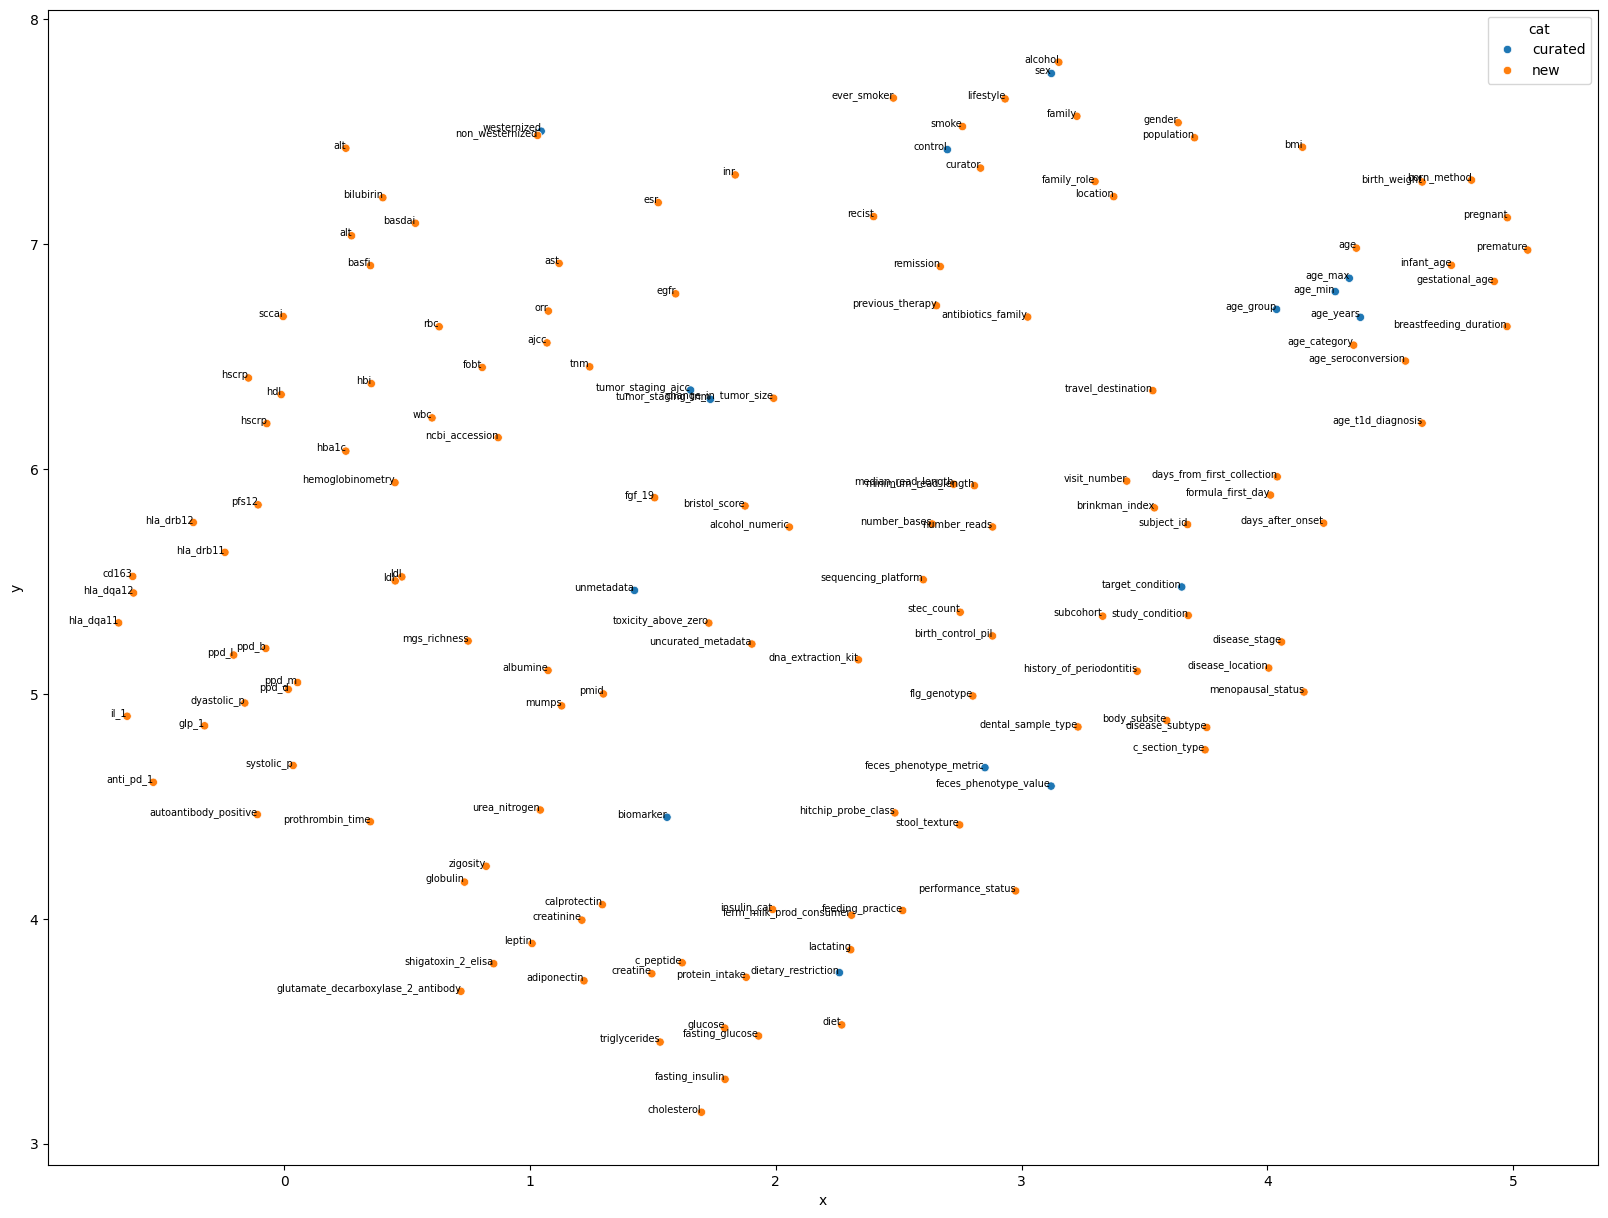

<Figure size 640x480 with 0 Axes>

In [36]:
ColumnsUMAP(curated_md, new_md, embedder, 20, 15, 7)

### Do the mapping of the remaining columns

In [37]:
# now we will find the closest column from new for each column of curated and ensure that their datatype is the same (just text-integer level 
# check) and then make a umap with lines showing the mappings, waiting for validation from the user. Then, the user will override some mappings 
# if needed and we will get our final mappings.

In [ ]:
# get the distances between the columns names for the two dataframes
distances = GetDistanceBetweenSentences(curated_md.columns, new_md.columns, embedder)

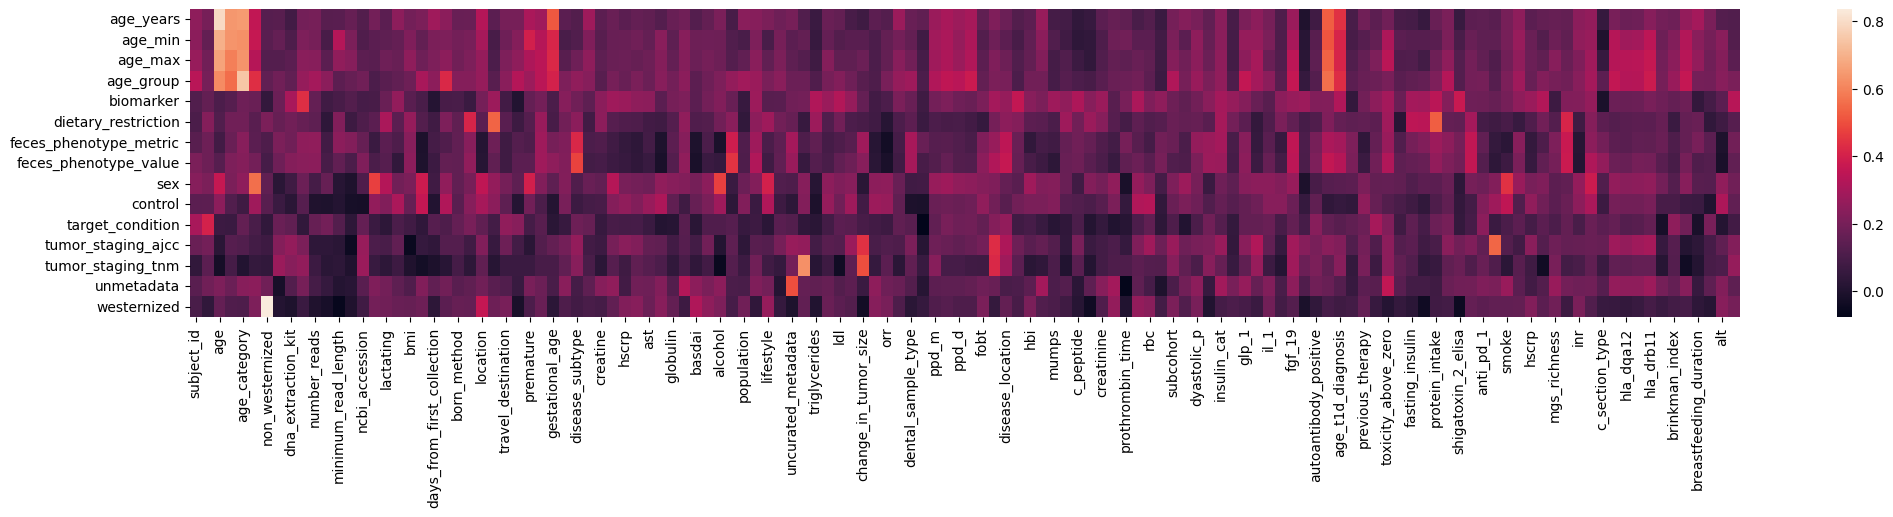

<Figure size 640x480 with 0 Axes>

In [ ]:
# just plotting the heatmap here too for an overview of the distances between column names
ColumnsHeatmap(curated_md, new_md, embedder, 25, 4)

In [71]:
# find the closest column to each of column from curated
mapping = {}
for itr, col in enumerate(curated_md.columns):
    # the key will be column from curated, and value will be best matching column from new
    mapping[col] = new_md.columns[np.argmax(distances[itr, :])]

/Users/shashankkatiyar/miniconda3/envs/gsoc/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


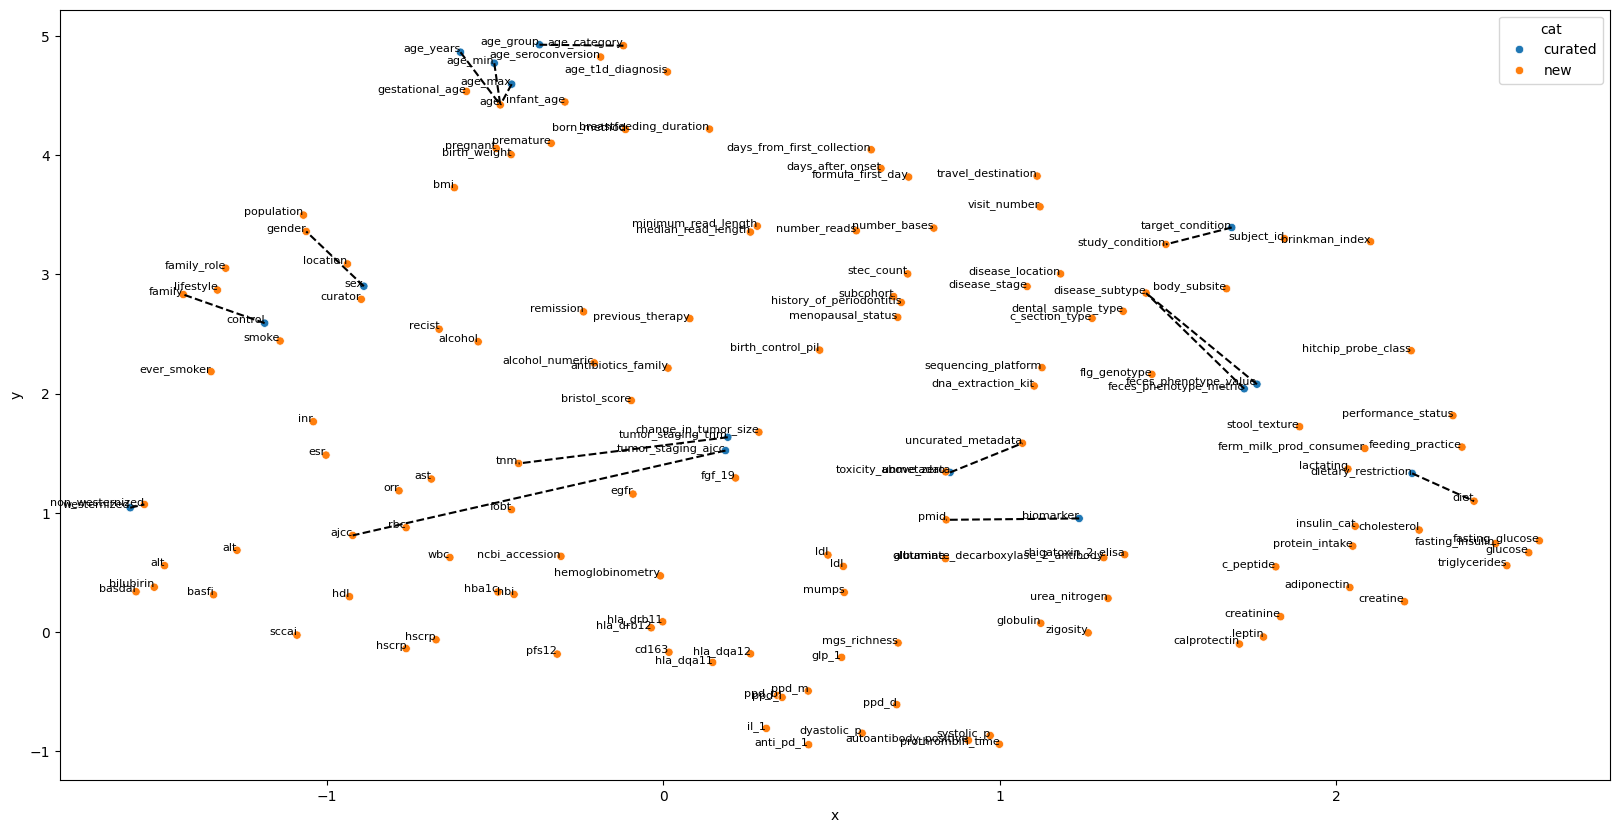

<Figure size 640x480 with 0 Axes>

In [103]:
# now visualize this information in a umap
ColumnsUMAP(curated_md, new_md, embedder, 20, 10, 8, mapping)

In [ ]:
# now after manually reviewing the umap, lets make the final mapping. 
# Also made use of the ydata_profiling reports generated in the previous step at this point. Basically roughly 
# looked into what entries are there in each column to make sure we are doing as best as we can for now in mapping 
# columns. The actual values in the columns can be tweaked later on. 
# Leaving those columns for which nothing was matched as empty strings. Will deal with them later. Egs- dietary_restriction, 

mapping_final = {
    'age_years' : 'age',
    'age_min' : 'age',
    'age_max' : 'age',
    'age_group' : 'age_category',
    'biomarker' : '',                           # PMID doesn't seem to be the best match for this
    'dietary_restriction' : '',                 # diet column is completely empty in new_md
    'feces_phenotype_metric' : 'stool_texture', # stool_texture would have been a better matching column than disease_subtype. UMAP helps in finding that out.    
    'feces_phenotype_value' : '',   
    'sex' : 'gender',
    'control' : '',                             # here, i believe study_condition should have been a better matching column than family (we can extract the information for control cases from it)
    'target_condition' : 'study_condition',     # one can argue that disease would have been a better match to target_condition, but study_condition is also good in my opinion
    'tumor_staging_ajcc' : 'ajcc',
    'tumor_staging_tnm' : 'tnm',
    'unmetadata' : 'uncurated_metadata',
    'westernized' : 'non_westernized',          # this is one of the cases where negation is present. Hence needs to be dealt with carefully.
}

In [108]:
# some ideas based on above steps: 
# - need to incorporate entries of columns when matching them, and not just use the col names (like for control). 
# - column datatype consideration while matching is also crucial.
# - need to highlight always where there has been a match in strings, even though there was negation in exactly one (like westernized and non-westernized).
# - the biomarker columns needs especially more work, because we will have to look into all columns which have some or the other kind of 
# biomarker information and combine information from them to fill up this column. Hence, for it, we have to run a separate analysis in which 
# we will find prospective biomarker columns and concat data from them and fill up our biomarker col, which is one of the future areas of work.